In [ ]:

import numpy as np 
import os
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

In [ ]:
#Setting up sweep configuration
sweep_config = {"name": "my-sweep-partB"}
sweep_config['method'] = 'grid'
metric = {
    'name': 'accuracy',
    'goal': 'maximize'   
    }
sweep_config['metric'] = metric
param_dict= {
      
          "preTrainModel":{
            "values": ['InceptionV3', 'Xception', 'InceptionResNetV2', 'ResNet50']
          },
          "augment_data": {
              "values": [True,False]
          },
          "dropout": {
              "values": [0.4]
          },
          "batchNorm": {
              "values": [True,False]
          },        
          "denseSize": {
              "values": [64, 128]
          },
          "epochs": {
              "values": [10]
          },
          "lr": {
              "values": [0.0003, 0.00002]
          }
      }

sweep_config["parameters"] = param_dict
sweep_id = wandb.sweep(sweep_config, project="cs6910_Assignment2_partB")

Create sweep with ID: si7konw4
Sweep URL: https://wandb.ai/cs21m073/cs6910_Assignment2_partB/sweeps/si7konw4


In [ ]:
##Creating the dataset from google drive
Path = '/content/drive/MyDrive/inaturalist_12K'

trainPath = os.path.join(Path, "train") #training data path
valPath = os.path.join(Path, "val") #validation data path

def createDataset(augmentData=False, preTrainedModel = 'InceptionV3'):
  imageSize = 299
  if preTrainedModel == 'InceptionV3':
    #default imageSize for inceptionv3 is 299
    imageSize = 299

  elif preTrainedModel == 'InceptionResNetV2':
    #default imageSize for inceptionv3 is 299
    imageSize = 299
    
  elif preTrainedModel == 'ResNet50':
    #default imageSize for inceptionv3 is 224
    imageSize = 224
    
  elif preTrainedModel == 'Xception':
    #default imageSize for inceptionv3 is 299
    imageSize = 299

  if augmentData == True:
    train_ = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, rotation_range=90, horizontal_flip=True, validation_split=0.1)
  else:
    train_ = ImageDataGenerator(rescale=1./255, validation_split=0.1)
  
  val_ = ImageDataGenerator(rescale=1./255)

  trainData = train_.flow_from_directory(trainPath, target_size=(imageSize, imageSize), batch_size=128, subset="training", shuffle =True, seed = 123)
  testData = train_.flow_from_directory(trainPath, target_size=(imageSize, imageSize), batch_size=128, subset="validation", shuffle = True, seed = 123)
  valData = val_.flow_from_directory(valPath, target_size=(imageSize, imageSize), batch_size=128)

  return trainData, testData, valData

  


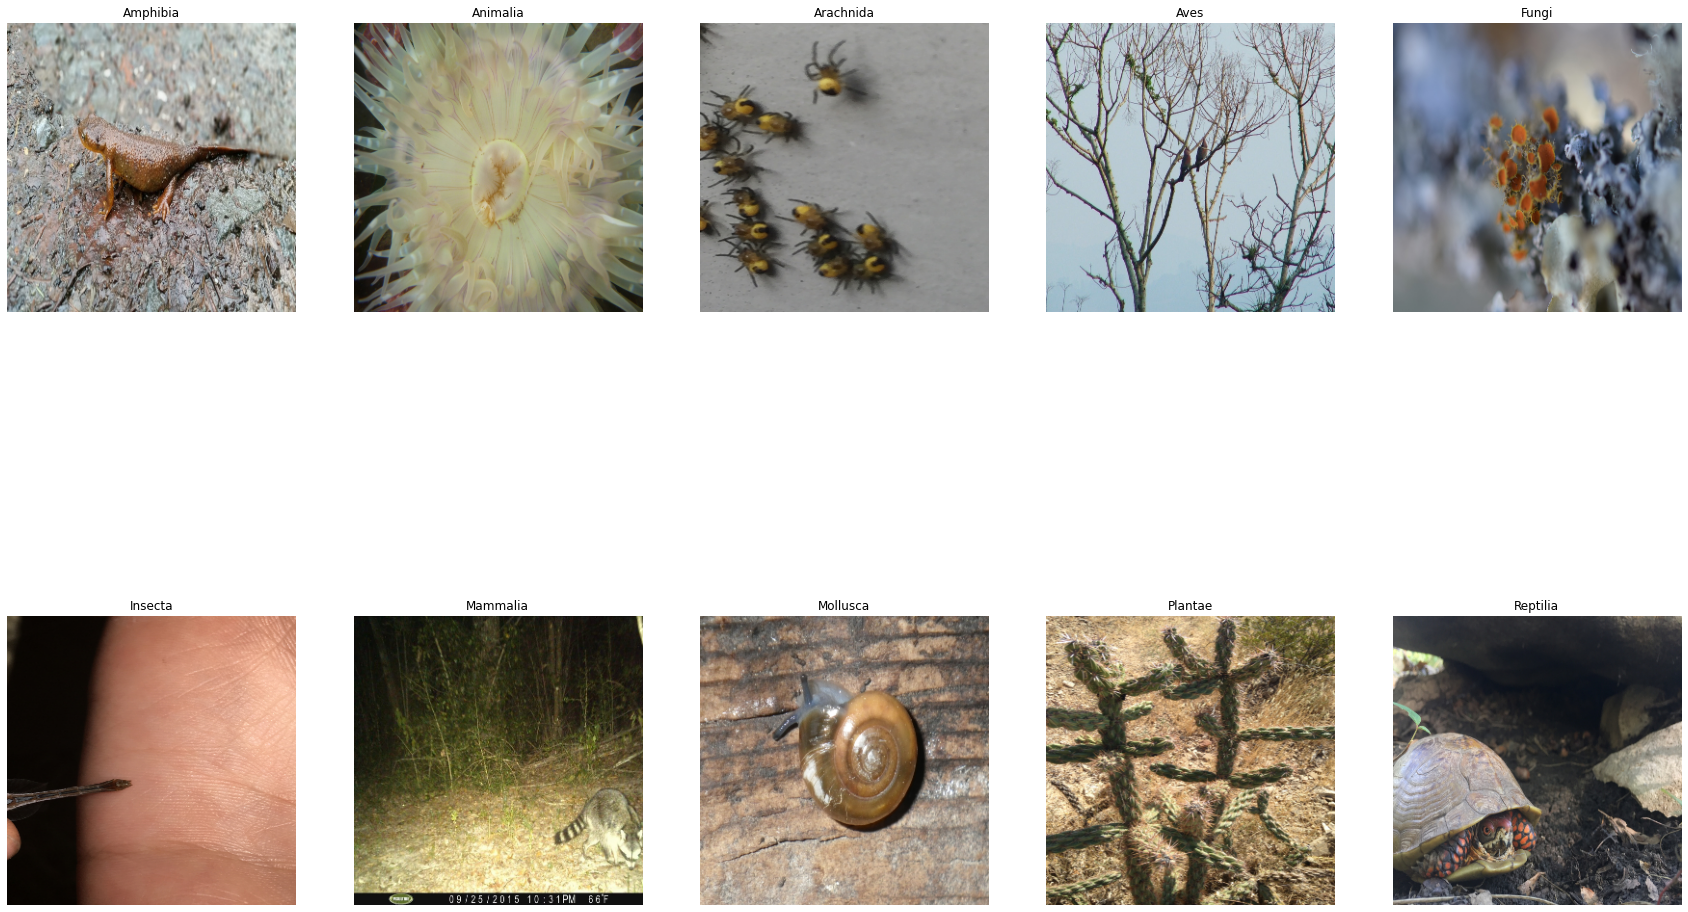

In [ ]:
#Lets see some images
CATEGORIES=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
fig = plt.figure(figsize=(30,20))
rows,columns=2,5
i=1
for category in CATEGORIES:
  DIR = os.path.join(trainPath,category)
  for img in os.listdir(DIR):
    imgPath=os.path.join(DIR,img)
    img=mpimg.imread(imgPath)
    newImg=cv2.resize(img,(300,300))
    fig.add_subplot(rows,columns,i)
    plt.imshow(newImg)
    plt.axis('off')
    plt.title(category)
    i+=1   
    break

In [ ]:
class NeuralNetwork:
  def __init__(self):
    pass

  def modelCreation(self, denseSize=128, imageSize=299, dropout=0.4, batchNorm=False, preTrainedModel='InceptionV3'):
    if preTrainedModel == 'InceptionV3':
      #default imageSize for inceptionv3 is 299
      imageSize = 299
      model = InceptionV3(include_top=False, input_shape=(imageSize, imageSize,3), weights='imagenet')

    elif preTrainedModel == 'InceptionResNetV2':
      #default imageSize for inceptionv3 is 299
      imageSize = 299
      model = InceptionResNetV2(include_top=False, input_shape=(imageSize, imageSize,3), weights='imagenet')
    
    elif preTrainedModel == 'ResNet50':
      #default imageSize for inceptionv3 is 224
      imageSize = 224
      model = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(imageSize, imageSize,3), weights='imagenet')
    
    elif preTrainedModel == 'Xception':
      #default imageSize for inceptionv3 is 299
      imageSize = 299
      model = Xception(include_top=False, input_shape=(imageSize, imageSize,3), weights='imagenet')  


    for layers in model.layers:
      layers.trainable = False

    model = keras.Sequential([
        tf.keras.Input(shape=(imageSize, imageSize,3,)), model, Flatten(), Dense(denseSize,activation='relu'),])
    
    if batchNorm:
      model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(denseSize, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(10 ,activation='softmax'))

    return model


    #Training the model
  def trainModel(self):
        
        config_defaults={
              'preTrainModel' : 'InceptionV3',
              'augment_data' : True,
              'dropout' : 0.4,
              'batchNorm' : True,
              'denseSize' : 128,
              'epochs' : 10,
              'lr' : 0.0003
        }

        wandb.init(config=config_defaults, magic=True)
        config = wandb.config
        wandb.run.name = "e_{}_augDat_{}_dropout_{}_bacthNorm_{}_denseSize_{}_preTrainedModel_{}_lr_{}".format(config.epochs, config.augment_data, config.dropout, config.batchNorm, config.denseSize, config.preTrainModel, config.lr)
        trainData, testData, valData = createDataset(config.augment_data, config.preTrainModel)

        #structure of modelCreation(self, denseSize=128, imageSize=299, dropout=0.4, batchNorm=False, preTrainedModel='inceptionv3'):
        model = self.modelCreation(config.denseSize, imageSize=299, dropout=config.dropout, batchNorm=config.batchNorm, preTrainedModel=config.preTrainModel)

       # model.compile(optimizer=keras.optimizers.Adam(config.lr), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
        #Training model and fine tuning
        tuningParameters = {
          "InceptionV3": 55,
          "InceptionResNetV2": 55,
          "ResNet50": 50,
          "Xception": 50
        }

        model.trainanle = True
        fineTuneTo = len(model.layers) - tuningParameters[wandb.config.preTrainModel]

        for layer in model.layers[:fineTuneTo]:
          layer.trainable =  False

        model.compile(optimizer=keras.optimizers.Adam(config.lr), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
        model.fit(trainData, epochs=config.epochs, validation_data=testData, callbacks=[WandbCallback()])
        print("Training and Tuning Completed")




In [ ]:
obj = NeuralNetwork()

In [ ]:
wandb.agent(sweep_id, function=obj.trainModel)

wandb: Agent Starting Run: zy46gmfb with config:
wandb: 	augment_data: True
wandb: 	batchNorm: True
wandb: 	denseSize: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	lr: 0.0003
wandb: 	preTrainModel: InceptionV3


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
71/71 [==============================] - 1196s 17s/step - loss: 1.4414 - accuracy: 0.5399 - val_loss: 0.8934 - val_accuracy: 0.7157 - _timestamp: 1648978800.0000 - _runtime: 1212.0000
Epoch 2/10
71/71 [==============================] - 309s 4s/step - loss: 1.0100 - accuracy: 0.6848 - val_loss: 0.8969 - val_accuracy: 0.7097 - _timestamp: 1648979111.0000 - _runtime: 1523.0000
Epoch 3/10
71/71 [==============================] - 307s 4s/step - loss: 0.9382 - accuracy: 0.7048 - val_loss: 0.8003 - val_accuracy: 0.7497 - _timestamp: 1648979417.0000 - _runtime: 1829.0000
Epoch 4/10
71/71 [==============================] - 309s 4s/step - loss: 0.8799 - accuracy: 0.7252 - val_loss: 0.7969 - val_accuracy: 0.7467 - _timestamp: 1648979726.0000 - _runtime: 2138.0000
Epoch 5/10
71/71 [==============================] - 305s 4s/step - loss: 0.8406 - accuracy: 0.7341

accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▂▁█▇▆▆▆███
val_loss,██▄▃▁▁▃▁▄▂
accuracy,0.76844
best_epoch,4
best_val_loss,0.74286
epoch,9
loss,0.71138
val_accuracy,0.75275


wandb: Agent Starting Run: m92tuko6 with config:
wandb: 	augment_data: True
wandb: 	batchNorm: True
wandb: 	denseSize: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	lr: 2e-05
wandb: 	preTrainModel: InceptionV3


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
71/71 [==============================] - 323s 4s/step - loss: 2.0058 - accuracy: 0.3747 - val_loss: 1.1306 - val_accuracy: 0.6597 - _timestamp: 1648981931.0000 - _runtime: 340.0000
Epoch 2/10
71/71 [==============================] - 312s 4s/step - loss: 1.3225 - accuracy: 0.5833 - val_loss: 0.9255 - val_accuracy: 0.7077 - _timestamp: 1648982246.0000 - _runtime: 655.0000
Epoch 3/10
71/71 [==============================] - 314s 4s/step - loss: 1.1442 - accuracy: 0.6450 - val_loss: 0.8309 - val_accuracy: 0.7397 - _timestamp: 1648982560.0000 - _runtime: 969.0000
Epoch 4/10
71/71 [==============================] - 309s 4s/step - loss: 1.0577 - accuracy: 0.6670 - val_loss: 0.8307 - val_accuracy: 0.7337 - _timestamp: 1648982870.0000 - _runtime: 1279.0000
Epoch 5/10
71/71 [==============================] - 312s 4s/step - loss: 0.9984 - accuracy: 0.6879 - va

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆██▇▇▇▇
val_loss,█▄▂▂▁▁▂▁▂▁
accuracy,0.72911
best_epoch,9
best_val_loss,0.75613
epoch,9
loss,0.86863
val_accuracy,0.75275


wandb: Agent Starting Run: kocaubun with config:
wandb: 	augment_data: True
wandb: 	batchNorm: False
wandb: 	denseSize: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	lr: 0.0003
wandb: 	preTrainModel: InceptionV3


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
71/71 [==============================] - 320s 4s/step - loss: 2.3645 - accuracy: 0.1737 - val_loss: 2.0113 - val_accuracy: 0.2833 - _timestamp: 1648985106.0000 - _runtime: 337.0000
Epoch 2/10
71/71 [==============================] - 312s 4s/step - loss: 2.1085 - accuracy: 0.2151 - val_loss: 1.9519 - val_accuracy: 0.2703 - _timestamp: 1648985419.0000 - _runtime: 650.0000
Epoch 3/10
71/71 [==============================] - 310s 4s/step - loss: 2.0865 - accuracy: 0.2258 - val_loss: 1.9388 - val_accuracy: 0.2793 - _timestamp: 1648985729.0000 - _runtime: 960.0000
Epoch 4/10
71/71 [==============================] - 303s 4s/step - loss: 2.0587 - accuracy: 0.2343 - val_loss: 1.8929 - val_accuracy: 0.3183 - _timestamp: 1648986044.0000 - _runtime: 1275.0000
Epoch 5/10
71/71 [==============================] - 307s 4s/step - loss: 2.0382 - accuracy: 0.2410 - va

accuracy,▁▄▅▆▆▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▃▂▂▂▁▁▁
val_accuracy,▂▁▂▅▃▇█▇▇█
val_loss,█▇▆▅▆▂▁▂▃▁
accuracy,0.26656
best_epoch,9
best_val_loss,1.72438
epoch,9
loss,1.96749
val_accuracy,0.36036


wandb: Agent Starting Run: vwopdggh with config:
wandb: 	augment_data: True
wandb: 	batchNorm: False
wandb: 	denseSize: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	lr: 2e-05
wandb: 	preTrainModel: InceptionV3


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
71/71 [==============================] - 323s 4s/step - loss: 2.0952 - accuracy: 0.2676 - val_loss: 1.5225 - val_accuracy: 0.5916 - _timestamp: 1648988238.0000 - _runtime: 341.0000
Epoch 2/10
71/71 [==============================] - 314s 4s/step - loss: 1.6101 - accuracy: 0.4698 - val_loss: 1.1766 - val_accuracy: 0.6817 - _timestamp: 1648988552.0000 - _runtime: 655.0000
Epoch 3/10
71/71 [==============================] - 318s 4s/step - loss: 1.4105 - accuracy: 0.5411 - val_loss: 1.0002 - val_accuracy: 0.7247 - _timestamp: 1648988877.0000 - _runtime: 980.0000
Epoch 4/10
71/71 [==============================] - 319s 4s/step - loss: 1.3121 - accuracy: 0.5836 - val_loss: 0.9521 - val_accuracy: 0.7247 - _timestamp: 1648989196.0000 - _runtime: 1299.0000
Epoch 5/10
71/71 [==============================] - 316s 4s/step - loss: 1.2244 - accuracy: 0.6104 - va

accuracy,▁▄▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▆▇█▇▇██
val_loss,█▅▃▂▂▁▂▁▁▁
accuracy,0.67244
best_epoch,9
best_val_loss,0.81977
epoch,9
loss,1.03874
val_accuracy,0.76476


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8dnxesvp with config:
wandb: 	augment_data: False
wandb: 	batchNorm: True
wandb: 	denseSize: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	lr: 0.0003
wandb: 	preTrainModel: InceptionV3


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
71/71 [==============================] - 156s 2s/step - loss: 1.2072 - accuracy: 0.6378 - val_loss: 0.7625 - val_accuracy: 0.7608 - _timestamp: 1648991293.0000 - _runtime: 172.0000
Epoch 2/10
71/71 [==============================] - 144s 2s/step - loss: 0.6838 - accuracy: 0.8028 - val_loss: 0.6432 - val_accuracy: 0.7938 - _timestamp: 1648991438.0000 - _runtime: 317.0000
Epoch 3/10
71/71 [==============================] - 148s 2s/step - loss: 0.5126 - accuracy: 0.8466 - val_loss: 0.6348 - val_accuracy: 0.7998 - _timestamp: 1648991587.0000 - _runtime: 466.0000
Epoch 4/10
71/71 [==============================] - 142s 2s/step - loss: 0.3780 - accuracy: 0.8912 - val_loss: 0.6467 - val_accuracy: 0.7998 - _timestamp: 1648991730.0000 - _runtime: 609.0000
Epoch 5/10
71/71 [==============================] - 142s 2s/step - loss: 0.2651 - accuracy: 0.9221 - val

accuracy,▁▄▅▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▅▆▆▆▇▆█▇▆
val_loss,▇▁▁▂▂▂▃▁▅█
accuracy,0.98367
best_epoch,2
best_val_loss,0.63475
epoch,9
loss,0.06673
val_accuracy,0.8038


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ff3y1oyh with config:
wandb: 	augment_data: False
wandb: 	batchNorm: True
wandb: 	denseSize: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	lr: 2e-05
wandb: 	preTrainModel: InceptionV3


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
71/71 [==============================] - 158s 2s/step - loss: 1.7084 - accuracy: 0.4689 - val_loss: 0.8535 - val_accuracy: 0.7628 - _timestamp: 1648992836.0000 - _runtime: 173.0000
Epoch 2/10
71/71 [==============================] - 147s 2s/step - loss: 0.9730 - accuracy: 0.7010 - val_loss: 0.6940 - val_accuracy: 0.7958 - _timestamp: 1648992984.0000 - _runtime: 321.0000
Epoch 3/10
71/71 [==============================] - 150s 2s/step - loss: 0.7808 - accuracy: 0.7638 - val_loss: 0.6449 - val_accuracy: 0.8058 - _timestamp: 1648993188.0000 - _runtime: 525.0000
Epoch 4/10
71/71 [==============================] - 148s 2s/step - loss: 0.6661 - accuracy: 0.8052 - val_loss: 0.6144 - val_accuracy: 0.8158 - _timestamp: 1648993335.0000 - _runtime: 672.0000
Epoch 5/10
71/71 [==============================] - 151s 2s/step - loss: 0.5750 - accuracy: 0.8331 - val

accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▆▇▇▆██
val_loss,█▄▃▂▁▂▁▂▁▁
accuracy,0.92133
best_epoch,9
best_val_loss,0.56944
epoch,9
loss,0.30489
val_accuracy,0.82783


wandb: Agent Starting Run: wlpoaml5 with config:
wandb: 	augment_data: False
wandb: 	batchNorm: False
wandb: 	denseSize: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	lr: 0.0003
wandb: 	preTrainModel: InceptionV3


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
71/71 [==============================] - 152s 2s/step - loss: 2.1120 - accuracy: 0.3009 - val_loss: 1.3616 - val_accuracy: 0.5636 - _timestamp: 1648994411.0000 - _runtime: 168.0000
Epoch 2/10
71/71 [==============================] - 144s 2s/step - loss: 1.5979 - accuracy: 0.4646 - val_loss: 1.1444 - val_accuracy: 0.6657 - _timestamp: 1648994608.0000 - _runtime: 365.0000
Epoch 3/10
71/71 [==============================] - 144s 2s/step - loss: 1.4039 - accuracy: 0.5388 - val_loss: 1.0543 - val_accuracy: 0.7037 - _timestamp: 1648994752.0000 - _runtime: 509.0000
Epoch 4/10
71/71 [==============================] - 144s 2s/step - loss: 1.2284 - accuracy: 0.5830 - val_loss: 0.9468 - val_accuracy: 0.7367 - _timestamp: 1648994895.0000 - _runtime: 652.0000
Epoch 5/10
71/71 [==============================] - 146s 2s/step - loss: 1.1783 - accuracy: 0.5991 - val

accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▇█▇▇███
val_loss,█▅▄▃▁▃▂▁▂▂
accuracy,0.68089
best_epoch,7
best_val_loss,0.81566
epoch,9
loss,0.93565
val_accuracy,0.77578


wandb: Agent Starting Run: wgro7r4m with config:
wandb: 	augment_data: False
wandb: 	batchNorm: False
wandb: 	denseSize: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	lr: 2e-05
wandb: 	preTrainModel: InceptionV3


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
71/71 [==============================] - 155s 2s/step - loss: 1.8720 - accuracy: 0.3654 - val_loss: 1.1148 - val_accuracy: 0.7317 - _timestamp: 1648995931.0000 - _runtime: 169.0000
Epoch 2/10
71/71 [==============================] - 144s 2s/step - loss: 1.2642 - accuracy: 0.5946 - val_loss: 0.8345 - val_accuracy: 0.7708 - _timestamp: 1648996075.0000 - _runtime: 313.0000
Epoch 3/10
71/71 [==============================] - 144s 2s/step - loss: 1.0138 - accuracy: 0.6851 - val_loss: 0.7340 - val_accuracy: 0.7938 - _timestamp: 1648996219.0000 - _runtime: 457.0000
Epoch 4/10
71/71 [==============================] - 143s 2s/step - loss: 0.8990 - accuracy: 0.7237 - val_loss: 0.6802 - val_accuracy: 0.8038 - _timestamp: 1648996362.0000 - _runtime: 600.0000
Epoch 5/10
71/71 [==============================] - 145s 2s/step - loss: 0.7928 - accuracy: 0.7542 - val

accuracy,▁▄▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▇▇▇▆▇▇█
val_loss,█▄▃▂▁▁▁▁▁▁
accuracy,0.84889
best_epoch,9
best_val_loss,0.61877
epoch,9
loss,0.48601
val_accuracy,0.81882


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
